# Imports and setup 

### Ultralytics

In [1]:
# Pip install method (recommended)

# !pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12042MiB)
Setup complete ✅ (24 CPUs, 31.1 GB RAM, 80.1/878.6 GB disk)


### Set home directory

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/media/alex/F882-9E28/Backup/Licenta


In [5]:
# %cd {HOME}
# !git clone https://github.com/ifzhang/ByteTrack.git
# %cd {HOME}/ByteTrack

# # workaround related to https://github.com/roboflow/notebooks/issues/80
# !sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

# !pip3 install -q -r requirements.txt
# !python3 setup.py -q develop
# !pip install -q cython_bbox
# !pip install -q onemetric
# # workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
# !pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


### ByteTracker

In [6]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

### Supervision

In [8]:
# !pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [9]:
from supervision.draw.color import ColorPalette
from supervision.draw.color import Color
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

### Bytetracker setup

In [10]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

### Yolov8x setup

In [11]:
# settings
MODEL = "yolov8x.pt"

In [13]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


#### Test yolo

In [10]:
!yolo task=detect mode=predict model=yolov8x.pt conf=0.25 source='https://cdn.theatlantic.com/media/mt/food/RTR2LP34edit.jpg'

Ultralytics YOLOv8.1.14 🚀 Python-3.8.10 torch-1.12.0a0+2c916ef.nv22.3 CUDA:0 (Orin, 7337MiB)
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs

Found https://cdn.theatlantic.com/media/mt/food/RTR2LP34edit.jpg locally at RTR2LP34edit.jpg
image 1/1 /home/jetson/Documents/Licenta/RTR2LP34edit.jpg: 384x640 20 persons, 2 bicycles, 5 backpacks, 13 handbags, 1 tie, 218.9ms
Speed: 28.4ms preprocess, 218.9ms inference, 46.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [10]:
model.model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [15]:
SOURCE_VIDEO_PATH = "/media/alex/F882-9E28/Videos/00001-converted.mp4"

TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result2.mp4"

print(f"SOURCE_VIDEO_PATH: {SOURCE_VIDEO_PATH}")
print(f"TARGET_VIDEO_PATH: {TARGET_VIDEO_PATH}")

VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

SOURCE_VIDEO_PATH: /media/alex/F882-9E28/Videos/00001-converted.mp4
TARGET_VIDEO_PATH: /media/alex/F882-9E28/Backup/Licenta/vehicle-counting-result2.mp4


VideoInfo(width=1440, height=1080, fps=25, total_frames=2559)

In [16]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - person, car, motorcycle, bus and truck
CLASS_ID = [0, 2, 3, 5, 7]
CLASS_ID_PEOPLE = [0]
CLASS_ID_VEHICLE = [2, 3, 5, 7]

#### Select counting lines coodrinates

In [15]:
# Select lines manually by clicking on the image
import cv2
import numpy as np

# Initialize global variables
points = []  # To store the points where you click
lines = []

# Callback function for mouse events
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # Left button click
        if len(points) < 2:  # Ensure we only have 2 points
            points.append((x, y))
            cv2.circle(img, (x, y), 5, (0, 0, 255), -1)  # Draw the dot
            if len(points) == 2:
                lines.append((points[0], points[1]))
                cv2.line(img, points[0], points[1], (255, 0, 0), 2)  # Draw the line
                print(f"Point 1: {points[0]}, Point 2: {points[1]}")  # Print coordinates
                cv2.imshow("image", img)  # Show the image with the line
                
    if len(points) == 2:  # Reset after 2 points for new line drawing
        points.clear()


# Create a black image
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
img = frame 
cv2.namedWindow("image")

font = cv2.FONT_HERSHEY_SIMPLEX
org1 = (50, 50)
org2 = (50, 75)
org3 = (50, 100)
fontScale = 1
color = (0, 0, 255)
thickness = 2
cv2.putText(img, 'Please select 2 lines and then close the window!', org1, font, fontScale, color, thickness, cv2.LINE_AA)
cv2.putText(img, 'Line1 is for pedestrians', org2, font, fontScale, color, thickness, cv2.LINE_AA)
cv2.putText(img, 'Line2 is for cars', org3, font, fontScale, color, thickness, cv2.LINE_AA)

cv2.setMouseCallback("image", click_event)

cv2.imshow("image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

line_start = Point(lines[0][0][0], lines[0][0][1])
line_end = Point(lines[0][1][0], lines[0][1][1])

line_cars_start = Point(lines[1][0][0], lines[1][0][1])
line_cars_end = Point(lines[1][1][0], lines[1][1][1])

print(f"line_start: {line_start}, line_end: {line_end}")
print(f"line_cars_start: {line_cars_start}, line_cars_end: {line_cars_end}")

Point 1: (607, 536), Point 2: (962, 628)
Point 1: (226, 968), Point 2: (936, 455)
line_start: Point(x=607, y=536), line_end: Point(x=962, y=628)
line_cars_start: Point(x=226, y=968), line_cars_end: Point(x=936, y=455)


### Predict

In [16]:
from tqdm.notebook import tqdm
import cv2


def annotate_with_counts(frame, people_count, vehicles_count, font_scale=1, thickness=2):
    # Set the position for the annotations on the frame
    position_people = (10, 30)
    position_vehicles = (10, 60)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, f"People crossed: {people_count}", position_people, font, font_scale, (255, 255, 0), thickness)
    cv2.putText(frame, f"Vehicles crossed: {vehicles_count}", position_vehicles, font, font_scale, (0, 255, 0), thickness)


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter_people = LineCounter(start=line_start, end=line_end)
line_counter_vehicles = LineCounter(start=line_cars_start, end=line_cars_end)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator_people = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)
line_annotator_vehicle = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2, color=Color(0, 255, 0))

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        detections_people = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        detections_vehicles = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask_people = np.array([class_id in CLASS_ID_PEOPLE for class_id in detections.class_id], dtype=bool)
        mask_vehicle = np.array([class_id in CLASS_ID_VEHICLE for class_id in detections.class_id], dtype=bool)
        detections_people.filter(mask=mask_people, inplace=True)
        detections_vehicles.filter(mask=mask_vehicle, inplace=True)
        print("DEBUG", len(detections_people.class_id))
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks_people = byte_tracker.update(
            output_results=detections2boxes(detections=detections_people),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracks_vehicles = byte_tracker.update(
            output_results=detections2boxes(detections=detections_vehicles),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        tracker_id_people = match_detections_with_tracks(detections=detections_people, tracks=tracks_people)
        tracker_id_vehicles = match_detections_with_tracks(detections=detections_vehicles, tracks=tracks_vehicles)
        detections.tracker_id = np.array(tracker_id)
        detections_people.tracker_id = np.array(tracker_id_people)
        detections_vehicles.tracker_id = np.array(tracker_id_vehicles)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        mask_people = np.array([tracker_id is not None for tracker_id in detections_people.tracker_id], dtype=bool)
        mask_vehicles = np.array([tracker_id is not None for tracker_id in detections_vehicles.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        detections_people.filter(mask=mask_people, inplace=True)
        detections_vehicles.filter(mask=mask_vehicles, inplace=True)

        # updating line counter
        line_counter_people.update(detections=detections_people)
        line_counter_vehicles.update(detections=detections_vehicles)
        # annotate and display frame
        line_annotator_people.annotate(frame=frame, line_counter=line_counter_people)
        line_annotator_vehicle.annotate(frame=frame, line_counter=line_counter_vehicles)
        # Display number of cars that crossed the line and number of people that crossed the line in the left corner of the frame

        annotate_with_counts(frame, line_counter_people.in_count + line_counter_people.out_count, line_counter_vehicles.in_count + line_counter_vehicles.out_count)

        sink.write_frame(frame)

  0%|          | 0/1753 [00:00<?, ?it/s]


0: 480x640 14 persons, 8 cars, 1 truck, 2 traffic lights, 236.8ms
Speed: 34.8ms preprocess, 236.8ms inference, 32.6ms postprocess per image at shape (1, 3, 480, 640)
DEBUG 14

0: 480x640 15 persons, 8 cars, 2 traffic lights, 257.0ms
Speed: 12.3ms preprocess, 257.0ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)
DEBUG 15

0: 480x640 16 persons, 8 cars, 2 traffic lights, 270.7ms
Speed: 9.7ms preprocess, 270.7ms inference, 6.9ms postprocess per image at shape (1, 3, 480, 640)
DEBUG 16

0: 480x640 16 persons, 8 cars, 2 traffic lights, 259.9ms
Speed: 8.4ms preprocess, 259.9ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)
DEBUG 16

0: 480x640 15 persons, 8 cars, 3 traffic lights, 1 handbag, 245.8ms
Speed: 11.3ms preprocess, 245.8ms inference, 7.0ms postprocess per image at shape (1, 3, 480, 640)
DEBUG 15

0: 480x640 14 persons, 8 cars, 2 traffic lights, 267.1ms
Speed: 9.1ms preprocess, 267.1ms inference, 9.6ms postprocess per image at shape (1, 3, 480, 

### Identify the traffic lights and see what colour they are

In [46]:
CLASS_ID_TRAFFIC_LIGHT = [9]

In [14]:
# !pip install ffmpeg-python
import ffmpeg

AUX_VIDEO_PATH = f"{HOME}/auxi.mp4"

(
	ffmpeg.input(SOURCE_VIDEO_PATH)
    .filter('fps', fps=12) # TODO: change to 12
	.output(AUX_VIDEO_PATH)
	.run()
)

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/aarch64-linux-gnu --incdir=/usr/include/aarch64-linux-gnu --arch=arm64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis -

KeyboardInterrupt: 

frame=   68 fps= 12 q=-1.0 Lsize=    1904kB time=00:00:05.41 bitrate=2879.1kbits/s speed=0.938x    
video:1902kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.086150%
[libx264 @ 0xaaaae47497a0] frame I:1     Avg QP:19.93  size:140178
[libx264 @ 0xaaaae47497a0] frame P:18    Avg QP:20.91  size: 60486
[libx264 @ 0xaaaae47497a0] frame B:49    Avg QP:24.29  size: 14656
[libx264 @ 0xaaaae47497a0] consecutive B-frames:  1.5%  5.9%  4.4% 88.2%
[libx264 @ 0xaaaae47497a0] mb I  I16..4:  4.8% 70.5% 24.7%
[libx264 @ 0xaaaae47497a0] mb P  I16..4:  1.3%  9.7%  2.1%  P16..4: 43.4% 21.2% 11.4%  0.0%  0.0%    skip:11.0%
[libx264 @ 0xaaaae47497a0] mb B  I16..4:  0.2%  0.7%  0.2%  B16..8: 43.5%  5.6%  1.3%  direct: 2.7%  skip:45.9%  L0:45.8% L1:44.6% BI: 9.6%
[libx264 @ 0xaaaae47497a0] 8x8 transform intra:72.1% inter:72.5%
[libx264 @ 0xaaaae47497a0] coded y,uvDC,uvAC intra: 77.4% 58.9% 8.2% inter: 20.1% 20.1% 0.3%
[libx264 @ 0xaaaae47497a0] i16 v,h,dc,p: 12% 28%  7% 53%


In [17]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1440, height=1080, fps=25, total_frames=1753)

In [19]:
!pip install traffic_light_classifier

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 5.6 MB/s eta 0:00:0000:0100:01m


In [17]:
import cv2
import numpy as np

def predict_traffic_light_color(frame):
    # Convert to HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # Define hue ranges for red, yellow, and green (these ranges might need adjustment)
    red_lower1 = np.array([0, 50, 50])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([160, 50, 50])
    red_upper2 = np.array([180, 255, 255])
    yellow_lower = np.array([20, 50, 50])
    yellow_upper = np.array([30, 255, 255])
    green_lower = np.array([40, 50, 50])
    green_upper = np.array([80, 255, 255])
    # Count pixels within each color range
    red_pixels = (cv2.inRange(hsv, red_lower1, red_upper1) > 0).sum() + (cv2.inRange(hsv, red_lower2, red_upper2) > 0).sum()
    yellow_pixels = (cv2.inRange(hsv, yellow_lower, yellow_upper) > 0).sum()
    green_pixels = (cv2.inRange(hsv, green_lower, green_upper) > 0).sum()
    # Determine the most prominent color
    print(f"red_pixels: {red_pixels}, yellow_pixels: {yellow_pixels}, green_pixels: {green_pixels}")
    if red_pixels <= 10 and yellow_pixels <= 10 and green_pixels <= 10:
        return "Unknown"
    if max(red_pixels, yellow_pixels, green_pixels) == red_pixels:
        return "Red"
    elif max(red_pixels, yellow_pixels, green_pixels) == yellow_pixels:
        return "Yellow"
    else:
        return "Green"


In [44]:
plt.style.use('seaborn-v0_8-white')
import traffic_light_classifier as tlc


model_traffic_light = tlc.Model()
model_traffic_light.compile()


Importing package 'traffic_light_classifier'...
  + Adding module 'helpers'...
  - Done!
  + Adding module 'tests'...
  - Done!
  + Adding module 'plots'...
  - Done!
  + Adding module 'modify_images'...
  - Done!
  + Adding module 'extract_feature'...
  - Done!
  + Adding module 'statistics'...
  - Done!
  + Adding module 'datasets'...
  - Done!
  + Adding module 'model'...
  - Done!
Package 'traffic_light_classifier' imported sucessfully !!
version 1.0.0


Compilation in progress... Please wait !!


#### <span style='color: green;'>Compilation complete !!</span>

0: 480x640 15 persons, 6 cars, 2 traffic lights, 1 stop sign, 34.9ms
Speed: 9.9ms preprocess, 34.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


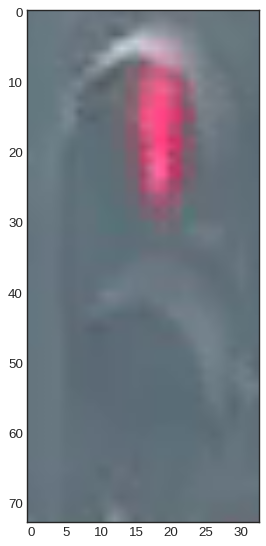

red_pixels: 175, yellow_pixels: 0, green_pixels: 0
Traffic light color: Red


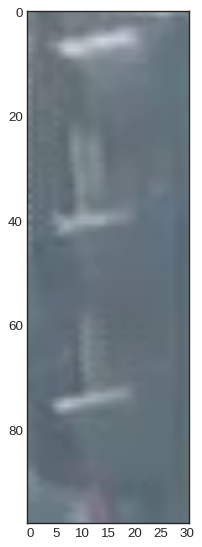

red_pixels: 0, yellow_pixels: 0, green_pixels: 0
Traffic light color: not visible


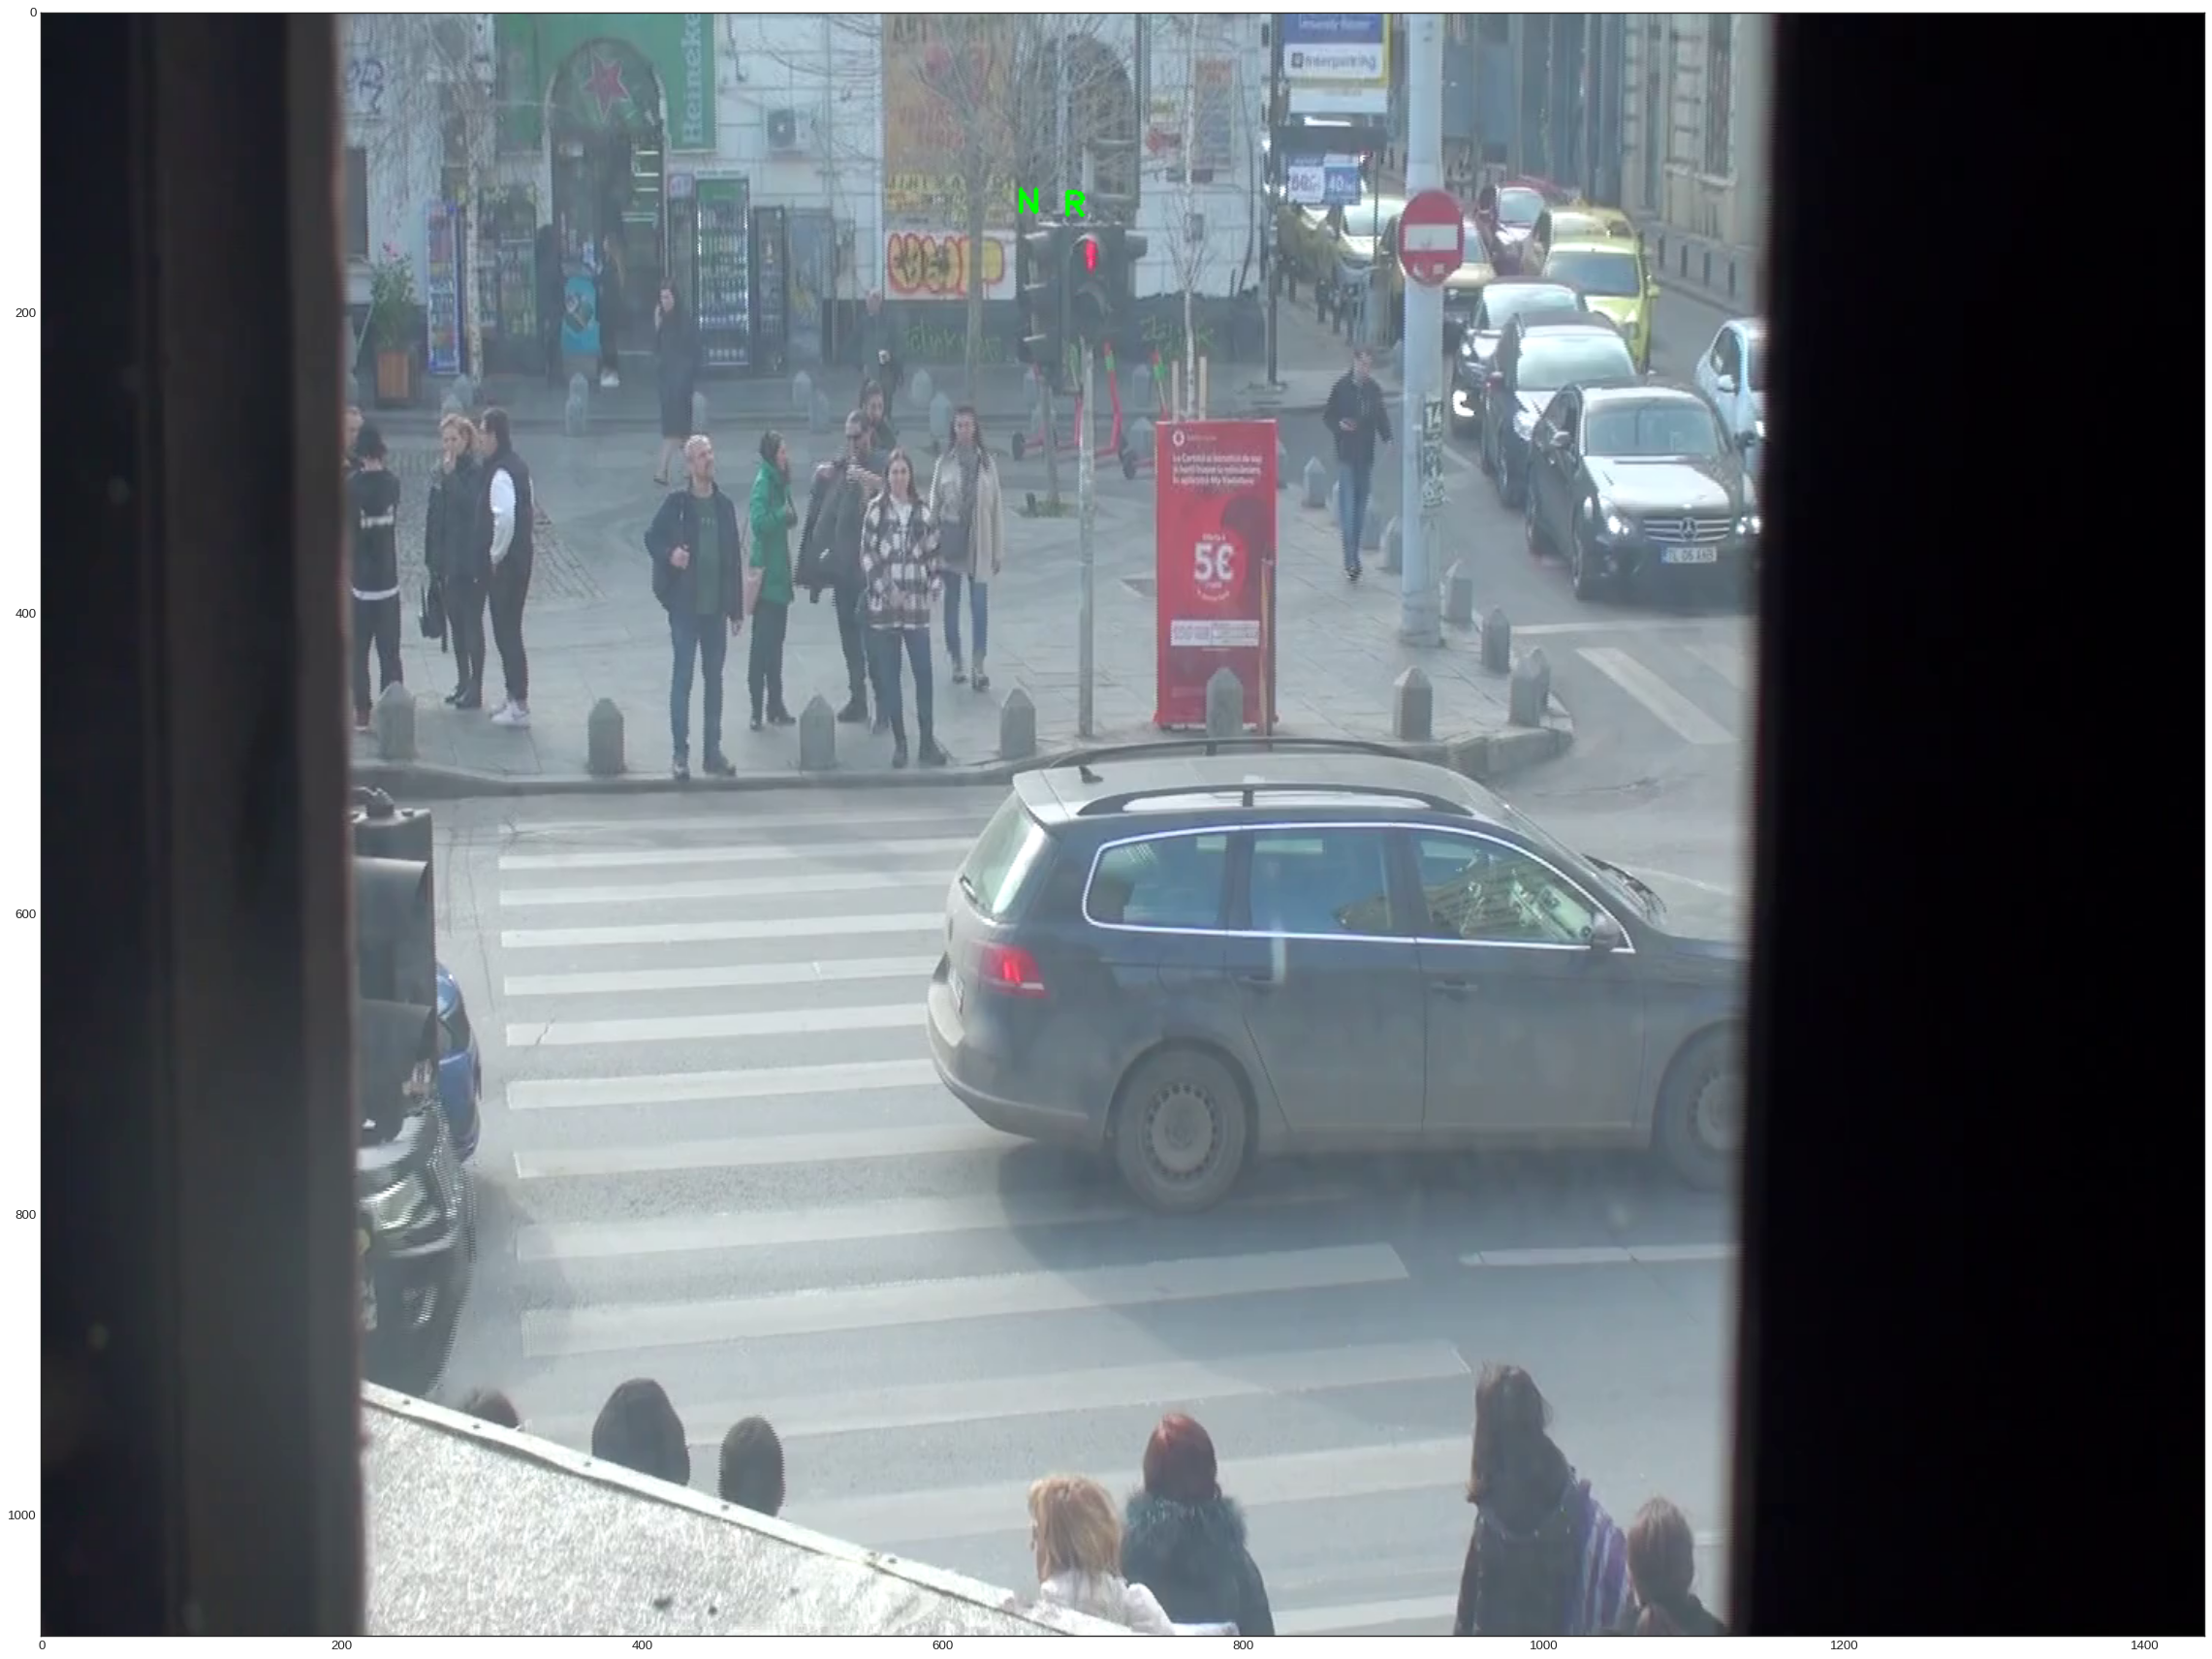

In [47]:
# create frame generator
from numpy import argmax


generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette())
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]

# filtering out detections with unwanted classes
mask_traffic_light= np.array([class_id in CLASS_ID_TRAFFIC_LIGHT for class_id in detections.class_id], dtype=bool)
detections.filter(mask=mask_traffic_light, inplace=True)

# Cut the box around the traffic light
for detection in detections.xyxy:
    %matplotlib inline
    x1, y1, x2, y2 = detection.astype(int)
    frame1 = frame[y1:y2, x1:x2]
    show_frame_in_notebook(frame1, (8, 8))

    # TODO: predict the color of the traffic light
    colours = ["Red", "Yellow", "Green"]
    color = predict_traffic_light_color(frame1)
    traffic_light_color = "Unknown"
    # print(f"Traffic light color: {color}")
    if color != "Unknown":
        frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
        pred = model_traffic_light.predict(frame1)
        if colours[argmax(pred)] != color:
            print(f"!!! hsv: {color}, nn: {colours[argmax(pred)]}")
        print(f"Traffic light color: {colours[argmax(pred)]}")
        traffic_light_color = colours[argmax(pred)]
    else:
        print("Traffic light color: not visible")
        traffic_light_color = "Not visible"

    text_position = (x1, y1 - 10 if y1 - 10 > 0 else y1 + 20)
    font_scale = 0.7  
    thickness = 2  
    cv2.putText(frame, traffic_light_color[0], text_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)

show_frame_in_notebook(frame, (36, 36))


In [65]:
from tqdm.notebook import tqdm
import cv2

# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        
        # filtering out detections with unwanted classes
        mask_traffic_light= np.array([class_id in CLASS_ID_TRAFFIC_LIGHT for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask_traffic_light, inplace=True)

        # Cut the box around the traffic light
        for detection in detections.xyxy:
            %matplotlib inline
            x1, y1, x2, y2 = detection.astype(int)
            frame1 = frame[y1:y2, x1:x2]

            # Predict the color of the traffic light
            colours = ["Red", "Yellow", "Green"]
            color = predict_traffic_light_color(frame1)
            traffic_light_color = "Unknown"
            # print(f"Traffic light color: {color}")
            if color != "Unknown":
                frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
                pred = model_traffic_light.predict(frame1, show_analysis=False)
                print(f"pred: {pred}")
                if colours[argmax(pred)] != color:
                    print(f"!!! hsv: {color}, nn: {colours[argmax(pred)]}")
                print(f"Traffic light color: {colours[argmax(pred)]}")
                traffic_light_color = colours[argmax(pred)]
            else:
                print("Traffic light color: not visible")
                traffic_light_color = "Not visible"

            text_position = (x1, y1 - 10 if y1 - 10 > 0 else y1 + 20)
            font_scale = 0.7  
            thickness = 2  
            cv2.putText(frame, traffic_light_color[0], text_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)

        sink.write_frame(frame)

  0%|          | 0/2559 [00:00<?, ?it/s]


0: 480x640 5 persons, 2 buss, 1 traffic light, 1 backpack, 239.9ms
Speed: 10.1ms preprocess, 239.9ms inference, 11.2ms postprocess per image at shape (1, 3, 480, 640)
red_pixels: 166, yellow_pixels: 0, green_pixels: 0


ValueError: attempt to get argmax of an empty sequence